In [145]:
import cv2

# QR
import pyzbar.pyzbar as pyzbar
from pyzbar.pyzbar import ZBarSymbol

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from client import Socket
from time import sleep

In [146]:
# have to edit this file, remove convex hull code
print(pyzbar.__file__)

/Users/joncomo/miniconda2/envs/py36/lib/python3.6/site-packages/pyzbar/pyzbar.py


In [147]:
# connect

s = Socket()

trying to connect to:  raspberrypi.local 5005
connected, use send_recv(msg) to send data


In [4]:
# start webcam

cap = cv2.VideoCapture(1)

In [72]:
# webcam input tracks any QR code
decodedObjects = []
def track(img):
    global decodedObjects
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (0,0), fx=0.6, fy=0.6)
    decodedObjects = pyzbar.decode(img, symbols=[ZBarSymbol.QRCODE])
    
    # Loop over all decoded objects
    points = []
    
    for decodedObject in decodedObjects: 
        points = decodedObject.polygon
 
    # If the points do not form a quad, find convex hull
    hull = points;
     
    # Number of points in the convex hull
    n = len(hull)
    
    if n == 0:
        return img, -1, -1, -1
 
    # Draw the convext hull
    for j in range(0,n):
        cv2.line(img, hull[j], hull[ (j+1) % n], (255,0,0), 3)
        
    # center
    cx = 0
    cy = 0
    
    # angle
    angle = np.arctan2(hull[0][1] - hull[1][1], hull[0][0] - hull[1][0])
    angle -= np.pi/2
    
    for i in range(n):
        cx += hull[i][0]
        cy += hull[i][1]
        
    cx /= float(n)
    cy /= float(n)
    
    cv2.circle(img, (int(cx), int(cy)), 5, color=(255,255,255), thickness=2)
    cv2.circle(img, (int(cx + np.cos(angle) * 50), int(cy + np.sin(angle) * 50)), 5, color=(255,255,255), thickness=2)
    
    cv2.putText(img,'{}, {}'.format(cx, cy), (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return img, cx, cy, angle
    
while True:
    ret, img = cap.read()
    img, cx, cy, angle = track(img)
    # Display results 
    cv2.imshow("Results", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [168]:
# send angles to servos

def move(angles, msg_type=0, sleep_time=1, accel=30):
    angles = np.round(angles, 2)
    data = "{},{},{},".format(msg_type, sleep_time, accel) + ",".join(map(str, angles))
    s.send(data)

angles = []
for t in np.linspace(0, 2*np.pi, 10):
    for i in range(8):
        angles.append(np.sin(t))
    
move(angles, sleep_time=.1, accel=60)

In [117]:
# brain

# new
W = np.random.randn(8, 4) * 1.1

# load
# W = np.load("brain_trained")

def transform(state, W):
    state = np.hstack([state, np.ones(1)]) # append 1
    z = W.dot(state)
    h = np.tanh(z)
    return h

def move_routine(state, W):
    states = np.array([])
    for t in np.linspace(0, 2 * np.pi, 30):
        state = W.dot(np.array([np.sin(t), np.sin(t*2), np.sin(t*3), -np.sin(t*4)]))
        #state = state * .5 + .5 * transform(state, W)
        states = np.hstack((states, state))
    move(states)
    sleep(31 * .05)

state = np.zeros(8)
move_routine(state, W)

In [63]:
# see effects of small perturbations

state = np.zeros(8)
move_routine(state, W + .3 * np.random.randn(W.shape[0], W.shape[1]))

In [25]:
# save good start W

#np.save("brain_starter", W)
#W = np.load("brain_starter.npy")

In [64]:
# data

diffs = []
rs = []

stand = np.zeros(8)
state = stand.copy()
move(state)
sleep(1)

out of bounds


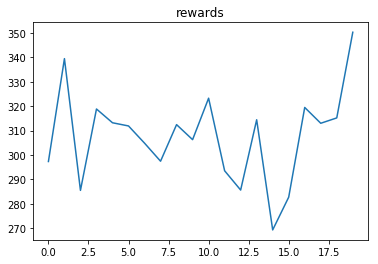

done


In [69]:
# training

for i in range(10):
    ret, img = cap.read()
    img, cx1, cy1, angle = track(img)
    
    angle -= np.pi/2.0
        
    targx = cx1 + np.cos(angle) * 200
    targy = cy1 + np.sin(angle) * 200
    
    cv2.imshow("Results", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
    if cx1 < 100 or cx1 > 600 or cy1 < 100 or cy1 > 400:
        print("out of bounds")
        break
    
    # try out a different W
    diff = np.random.randn(W.shape[0], W.shape[1]) * .3
    trialW = W + diff
    move_routine(state, trialW)
    sleep(1.5)
    
    ret, img = cap.read()
    img, cx2, cy2, angle = track(img)
    
    dx = cx2 - targx
    dy = cy2 - targy
    dist = np.sqrt(dx*dx + dy*dy)
    
    r = 500 - dist
    
    rs.append(r)
    diffs.append(diff)
    
    cv2.imshow("Results", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
plt.title("rewards")
plt.plot(rs)
plt.show()

print("done")

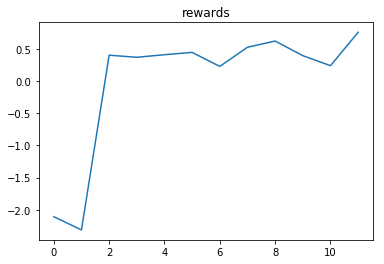

In [435]:
# normalize rewards

rs_norm = np.array(rs)
rs_norm -= np.mean(rs_norm)
rs_norm /= np.std(rs_norm)

plt.title("rewards")
plt.plot(rs_norm)
plt.show()

In [436]:
# train

print("Training based on {} collected: ".format(len(diffs)))
learning_rate = .1
for i in range(len(diffs)):
    W += diffs[i] * rs_norm[i] * learning_rate

Training based on 12 collected: 


In [234]:
# save brain
# np.save('brain_trained', W)

In [ ]:
# test it out
ret, img = cap.read()
img, cx1, cy1, angle = track(img)

targ_angle = np.random.random() * np.pi * 2.0

targx = cx1 + np.cos(angle) * 500
targy = cy1 + np.sin(angle) * 500

cv2.imshow("Results", img)
if cv2.waitKey(1) & 0xFF == ord('q'):
    pass

for _ in range(3):
    move_routine(state, W)
    
sleep(1)

ret, img = cap.read()
img, cx2, cy2, angle = track(img)

cv2.imshow("Results", img)
if cv2.waitKey(1) & 0xFF == ord('q'):
    pass

In [50]:
# reset state if needed

state = stand.copy()
move(state)

In [6]:
# release the capture

cap.release()
cv2.destroyAllWindows()